In [1]:
from pyNN.random import RandomDistribution, NumpyRNG
from pyNN import neuron
import pyNN.space as space
import pyNN
import pyNN.neuron as sim
import numpy as np
from pyNN.utility.plotting import Figure, Panel
from pyNN.space import Grid2D, RandomStructure, Sphere
import matplotlib.pyplot as plt
from neuroml import Morphology, Segment, Point3DWithDiam as P
from pyNN.morphology import NeuroMLMorphology, NeuriteDistribution, Morphology as Morph, IonChannelDistribution
from pyNN.neuron.morphology import uniform, random_section, random_placement, at_distances, apical_dendrites, dendrites, centre
from pyNN.parameters import IonicSpecies
from pyNN.standardmodels import StandardIonChannelModel, build_translations
from pyNN.neuron import NativeCellType
import shutil
import os
from neuron import h, nrn, hclass
from pyNN.utility.build import compile_nmodl
from pyNN.standardmodels.cells import MultiCompartmentNeuron as mc
import platform

/home/rnwatanabe/Modelo-Motoneuronio/modelpynn/lib/python3.10/site-packages/pyNN/neuron/__init__.py:14: UserWarning: mpi4py not available
  warnings.warn("mpi4py not available")


In [2]:
if platform.system() == 'Linux':
    shutil.copyfile('mn.mod','modelpynn/lib/python3.10/site-packages/pyNN/neuron/nmodl/mn.mod')
    compile_nmodl('modelpynn/lib/python3.10/site-packages/pyNN/neuron/nmodl/')
    h.nrn_load_dll('modelpynn/lib/python3.10/site-packages/pyNN/neuron/nmodl/mn.o')
if platform.system() == 'Windows':
    shutil.copyfile('mn.mod','modelpynn/Lib/site-packages/pyNN/neuron/nmodl/mn.mod')
    compile_nmodl('modelpynn/Lib/site-packages/pyNN/neuron/nmodl')
    h.nrn_load_dll('modelpynn/Lib/site-packages/pyNN/neuron/nmodl/mn.o')


nrnivmodl found at /home/rnwatanabe/Modelo-Motoneuronio/modelpynn/bin/nrnivmodl
Successfully compiled NEURON extensions.


In [3]:
class SetRate(object):
    """
    A callback which changes the firing rate of a population of poisson
    processes at a fixed interval.
    """

    def __init__(self, population_source, population_neuron, interval=20.0):
        self.population_source = population_source
        self.population_neuron = population_neuron
        self.interval = interval
        
    def __call__(self, t):
        rate = 50+20*np.sin(0.1*t)
        print(rate)
        self.population_source.set(rate=rate)
        return t + self.interval


In [4]:
class KsChannel(StandardIonChannelModel):
    default_parameters = {
        "conductance_density": 0.12, #uniform('all', 0.12),
        "e_rev": -80,
        "vt": -57.65
    }
    
    translations = build_translations(
        ('conductance_density', 'gk_slow'),
        ('e_rev', 'eks'),
        ('vt', 'vt'),
    )
    variable_translations = {
        'p': ('motoneuron', 'p'),
    }
    default_initial_values = {
        'p': 1,  # initial value for gating variable m
    }
    units = {
        'iks': 'mA/cm2',
        'p': 'dimensionless',
    }
    recordable = ['iks','p']
    model = "motoneuron"
    conductance_density_parameter = 'gk_slow'
    def get_schema(self):
        return {
            "conductance_density": IonChannelDistribution,
            "e_rev": float,
            "vt": float
        }

In [5]:
class KfChannel(StandardIonChannelModel):
    default_parameters = {
        "conductance_density": 0.12, #uniform('all', 0.12),
        "e_rev": -80,
        "vt": -57.65
    }
    
    recordable = ['ikf','n'] 
    translations = build_translations(
        ('conductance_density', 'gk_fast'),
        ('e_rev', 'ekf'),
        ('vt', 'vt'),
    )
    variable_translations = {
        'n': ('motoneuron', 'n'),
    }
    default_initial_values = {
        'n': 1,  # initial value for gating variable m
    }
    units = {
        'ikf': 'mA/cm2',
        'n': 'dimensionless',
    }
    model = "motoneuron"
    conductance_density_parameter = 'gk_fast'
    def get_schema(self):
        return {
            "conductance_density": IonChannelDistribution,
            "e_rev": float,
            "vt": float
        }

In [6]:
class NaChannel(StandardIonChannelModel):
    default_parameters = {
        "conductance_density": 0.12, #uniform('all', 0.12),
        "e_rev": 50,
        "vt":-57.65,
    }
    
    default_initial_values = {
        'm': 1.0,  # initial value for gating variable m
        'h': 0.0,  # initial value for gating variable h
    }
    recordable = ['ina', 'm', 'h']
    units = {
        'ina': 'mA/cm2',
        'm': 'dimensionless',
        'h': 'dimensionless',
    }
    translations = build_translations(
        ('conductance_density', 'gna'),
        ('e_rev', 'ena'),
        ('vt', 'vt'),
    )
    variable_translations = {
        'h': ('motoneuron', 'h'),
        'm': ('motoneuron', 'm'),
        'ina': ('motoneuron', 'ina'),
    }
    model = "motoneuron"
    conductance_density_parameter = 'gna'
    def get_schema(self):
        return {
            "conductance_density": IonChannelDistribution,
            "e_rev": float,
            "vt": float
        }

In [7]:
class PassiveLeak(StandardIonChannelModel):
    translations = build_translations(
        ('conductance_density', 'gl'),
        ('e_rev', 'el'),
    )
    variable_translations = {}
    model = "motoneuron"
    conductance_density_parameter = 'gl'

In [8]:
sim.setup(timestep=0.05)

soma1 = Segment(proximal=P(x=77.5, y=0, z=0, diameter=77.5),
               distal=P(x=0, y=0, z=0, diameter=77.5),
               name="soma", id=0)
soma2 = Segment(proximal=P(x=82.5, y=0, z=0, diameter=82.5),
               distal=P(x=0, y=0, z=0, diameter=82.5),
               name="soma", id=0)
dend1 = Segment(proximal=P(x=0, y=18, z=0, diameter=41.5),
               distal=P(x=-5500, y=18, z=0, diameter=41.5),
               name="dendrite",
               parent=soma1, id=1)
dend2 = Segment(proximal=P(x=0, y=0, z=0, diameter=62.5),
               distal=P(x=-6789, y=0, z=0, diameter=62.5),
               name="dendrite",
               parent=soma2, id=1)

class cell_class(sim.MultiCompartmentNeuron):


    def __init__(self, **parameters):

        self.label = "mn1"
        self.ion_channels = {'pas_soma': PassiveLeak, 'pas_dend': sim.PassiveLeak,
                           'na': NaChannel, 'kf': KfChannel, 'ks': KsChannel}
        self.units = {'v':'mV',
                      'gsyn_exc': 'uS',
                      'gsyn_inh': 'uS',
                      'na.m': 'dimensionless', 'na.h': 'dimensionless', 'kf.n': 'dimensionless', 'ks.p': 'dimensionless',
                      'na.ina': 'mA/cm2', 'kf.ikf': 'mA/cm2', 'ks.iks': 'mA/cm2'}
        self.post_synaptic_entities = {'syn': sim.CondExpPostSynapticResponse}
        
        super(cell_class, self).__init__(**parameters)
    
   


In [9]:
cell_type = cell_class(
    morphology=[NeuroMLMorphology(Morphology(segments=(soma1, 
                                                       dend1))),
                NeuroMLMorphology(Morphology(segments=(soma2, 
                                                       dend2)))],
    cm=1,    # mF / cm**2
    Ra=0.070, # ohm.mm
    ionic_species={"na": IonicSpecies("na", reversal_potential=50),
                   "ks": IonicSpecies("ks", reversal_potential=-80),
                   "kf": IonicSpecies("kf", reversal_potential=-80)
                  },
    pas_soma = {"conductance_density": uniform('soma', 7e-4), "e_rev":-70},
    pas_dend = {"conductance_density": uniform('dendrite', 7e-4), "e_rev":-70},
    na = {"conductance_density": uniform('soma', 10), "vt":[-57.65, -53]},
    kf = {"conductance_density": uniform('soma', 1), "vt":[-57.65, -53]},
    ks = {"conductance_density": uniform('soma', 0.5), "vt":[-57.65, -53]},

    syn={
        "locations": centre('dendrite'),
        "e_syn": 0,
        "tau_syn": 0.6},  
)

In [10]:
cells = sim.Population(2, cell_type, initial_values={'v': [-70, -70]})

In [11]:
cells[0]._cell.synaptic_receptors

{'syn': defaultdict(list, {1: [ExpSyn[0]]})}

In [12]:
np.random.seed(26278342)
spike_source = sim.Population(400, sim.SpikeSourcePoisson())
# spike_source.set(rate=83)
syn = sim.StaticSynapse(weight=0.6, delay=0.2)
input_conns = sim.Projection(spike_source, cells, 
                             sim.FixedProbabilityConnector(0.3, location_selector='dendrite'), 
                             syn, receptor_type="syn")

In [13]:
# step_current_dend = sim.DCSource(amplitude=7000, start=0, stop=50)
#step_current.inject_into(cells[1:2], location=apical_dendrites(fraction_along=0.9))
#step_current.inject_into(cells[1:2], location=random(after_branch_point(3)(apical_dendrites))
# step_current_dend.inject_into(cells[0:2], location='dendrite')

In [14]:
spike_source.record('spikes')
cells.record('spikes')
cells[0:2].record('v', locations=('dendrite','soma'))
cells[0:2].record(('na.m', 'na.h'), locations='soma')
cells[0:2].record(('kf.n'), locations='soma')
cells[0:2].record(('ks.p'), locations='soma')


In [15]:
sim.run(1000)#, callbacks=[SetRate(spike_source, cells)])

999.9999999993644

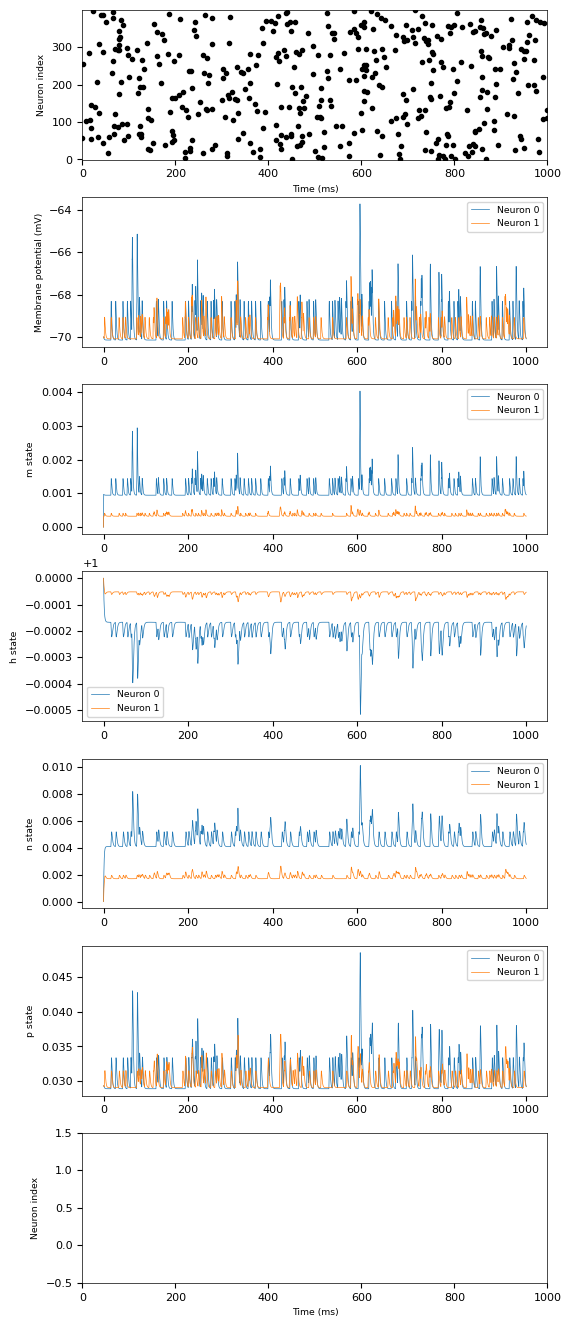

In [16]:
figure_filename = 'teste.png'
data_source = spike_source.get_data().segments[0]
data = cells.get_data().segments[0]
vm = data.filter(name="soma.v")[0]
m = data.filter(name="soma.na.m")[0]
h = data.filter(name="soma.na.h")[0]
n = data.filter(name="soma.kf.n")[0]
p = data.filter(name="soma.ks.p")[0]
# ina = data.filter(name="soma.na.ina")[0]
# ik = data.filter(name="ik")[0]

# gsyn = data.filter(name="gsyn_exc")[0]
Figure(
    Panel(data_source.spiketrains, xlabel="Time (ms)", xticks=True, yticks=True),
    Panel(vm, ylabel="Membrane potential (mV)", xticks=True, yticks=True),
    Panel(m, ylabel="m state", xticks=True, yticks=True),
    Panel(h, ylabel="h state", xticks=True, yticks=True),
    Panel(n, ylabel="n state", xticks=True, yticks=True),
    Panel(p, ylabel="p state", xticks=True, yticks=True),
    # Panel(ina, ylabel="i_na (mA)", xticks=True, yticks=True),
    # Panel(ik, ylabel="i_k (mA)", xticks=True, yticks=True),
    
    # Panel(gsyn, ylabel="Synaptic conductance (uS)"),
    Panel(data.spiketrains, xlabel="Time (ms)", xticks=True, yticks=True),
).save(figure_filename)


In [19]:
dir(spike_source)

['__add__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_assembly_class',
 '_create_cells',
 '_get_cell_initial_value',
 '_get_cell_position',
 '_get_native_parameters',
 '_get_parameters',
 '_get_positions',
 '_get_structure',
 '_get_view',
 '_is_sorted',
 '_mask_local',
 '_nPop',
 '_native_rset',
 '_positions',
 '_record_filter',
 '_recorder_class',
 '_set_cell_initial_value',
 '_set_cell_position',
 '_set_initial_value_array',
 '_set_parameters',
 '_set_positions',
 '_set_structure',
 '_simulator',
 '_structure',
 'all',
 'all_cells',
 'annotate',
 'annotations',
 'can_record',
 'celltype',
 'conductance_based',
 'descri